In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as stats
from toolz.curried import *
import itertools

import gc_model as gc
import hic_analysis as hic
import visualize

In [212]:
@curry
@excepts(FileNotFoundError)
def fit_dir(d, n):
    return np.load(f'{d}/{n}.npz')

eye = fit_dir('eye')ס
eye_with_empty = fit_dir('eye_with_empty')
diag = fit_dir('diag')

In [54]:
@curry
def unpack_args(f, args_list):
    return f(*args_list)

unzip = lambda zipped: zip(*zipped)

In [17]:
def plot_params(lambdas, weights, alpha):
    plt.imshow(hic.safe_log(gc.generate_interactions_matrix(lambdas, weights, alpha)))

def plot_params_normalized(lambdas, weights, alpha):
    plt.imshow(hic.safe_log(hic.normalize_distance(gc.generate_interactions_matrix(lambdas, weights, alpha))))

In [28]:
@curry
def likelihood(interactions_mat, fit_mat):
    clean_interactions_mat = gc.preprocess(interactions_mat)
    unique_interactions = gc.get_unique_interactions(clean_interactions_mat)
    clean_fit_mat = gc.preprocess(fit_mat)
    unique_fit_interactions = gc.get_unique_interactions(clean_fit_mat)

    return np.nansum(unique_interactions * hic.safe_log(unique_fit_interactions))

@curry
def likelihood_ratio(interactions_mat, fit_mat):
    return np.exp(likelihood(interactions_mat, fit_mat) - likelihood(interactions_mat, interactions_mat))

In [21]:
input_data = np.load('Rao2015_chr20_20000.npy')
likelihood_input = compose(likelihood(input_data), gc.generate_interactions_matrix)
lr_input = compose(likelihood_ratio(input_data), gc.generate_interactions_matrix)

In [51]:
lr_eye = compose(list,
                 map(juxt(first,
                          compose(unpack_args(lr_input), operator.methodcaller('values'), second))),
                 filter(compose(operator.is_not(None), second)),
                 map(juxt(identity, eye)))(range(101))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
54
55
56
57
58
59
60
61
62
63
64
66
67
68
69
71
72
73
74
75
78
79
80
81
82
84
85
87
88
89
90
91
92
94
95
96
97
99


In [ ]:
lr_eye_with_empty = compose(list,
                 map(juxt(first,
                          compose(unpack_args(lr_input), operator.methodcaller('values'), second))),
                 filter(compose(operator.is_not(None), second)),
                 map(juxt(identity, eye_with_empty)))(range(2, 101))

In [213]:
lr_diag = compose(list,
                 map(juxt(first,
                          compose(unpack_args(lr_input), operator.methodcaller('values'), second))),
                 filter(compose(operator.is_not(None), second)),
                 map(juxt(identity, diag)))(range(2, 101))

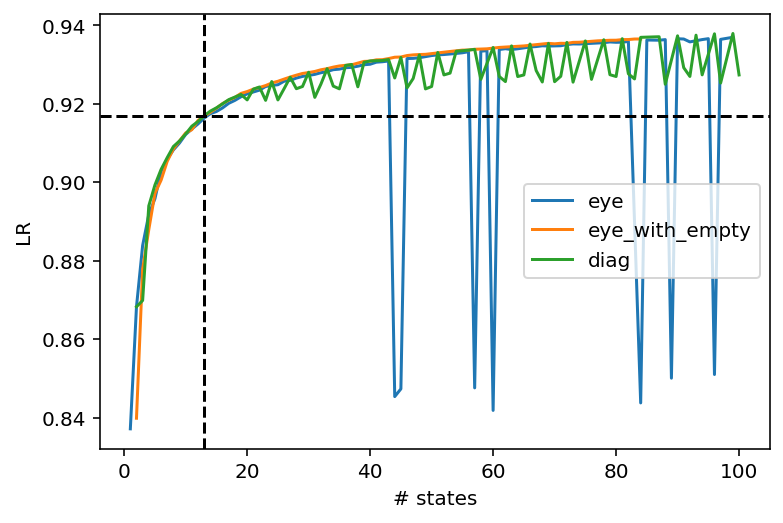

In [611]:
%matplotlib qt5
n_states, lr_n = unzip(lr_eye)
increase = lr_n[0] + (lr_n[-1] - lr_n[0]) * 0.80
increase_n = np.where(np.array(lr_n) > increase)[0][0]
plt.plot(n_states, lr_n)
plt.plot(*unzip(lr_eye_with_empty))
plt.plot(*unzip(lr_diag))
plt.legend(['eye', 'eye_with_empty', 'diag'])
plt.xlabel('# states')
plt.ylabel("LR")
plt.axvline(increase_n, linestyle='--', c='k')
plt.axhline(increase, linestyle='--', c='k')

In [396]:
pluck_lambdas = pluck('lambdas')
pluck_weights = pluck('weights')
pluck_alpha = pluck('alpha')

def Ms(i=10):
    while True:
        yield f'M={i}'
        i+=10
        
def sort_weights(weights):
    self_weights = np.diag(weights)
    M = self_weights.size
    weights_order = np.argsort(self_weights)
    sorted_weights = np.empty_like(weights)
    for i in range(M):
        w_i = weights_order[i]
        for j in range(M):
            w_j = weights_order[j]
            sorted_weights[i, j] = weights[w_i, w_j]
    return sorted_weights, weights_order

def plot_all(fit, order_func=None):
    if order_func is None:
        order_func = lambda i, w, s, m, sd: np.argsort(w)
    lambdas_colsum = compose(map(partial(np.nansum, axis=0)), pluck_lambdas)(fit)
    lambdas_colmax = compose(map(partial(np.nanmax, axis=0)), pluck_lambdas)(fit)
    lambdas_stdev = compose(map(partial(np.nanstd, axis=0)), pluck_lambdas)(fit)
    w_diag = compose(map(np.diag), pluck_weights)(fit)

    cols = 4
    n = len(fit)
    plt.figure(figsize=(4*1.5 * cols, 3*1.5 * n))
    for i, w, s, m, sd in zip(itertools.count(1), w_diag, lambdas_colsum, lambdas_colmax, lambdas_stdev):
        order = order_func(i, w, s, m, sd)
        
        ax = plt.subplot(n, cols, cols*(i-1) + 1)
        plt.plot(w[order])
        if ax.is_first_row():
            plt.title("Weights (diag)")
        plt.ylabel(f'M={fit[i-1]["weights"].shape[0]}')
        
        ax = plt.subplot(n, cols, cols*(i-1) + 2)
        plt.plot(s[order])
        plt.axvline(0, c='k', linestyle='--')
        if ax.is_first_row():
            plt.title("Lambdas sum")
            
        ax = plt.subplot(n, cols, cols*(i-1) + 3)
        plt.plot(m[order])
        plt.axvline(0, c='k', linestyle='--')
        if ax.is_first_row():
            plt.title("Lambdas max")
            
        ax = plt.subplot(n, cols, cols*(i-1) + 4)
        plt.plot(sd[order])
        plt.axvline(0, c='k', linestyle='--')
        if ax.is_first_row():
            plt.title("Lambdas stddev")
    plt.tight_layout()

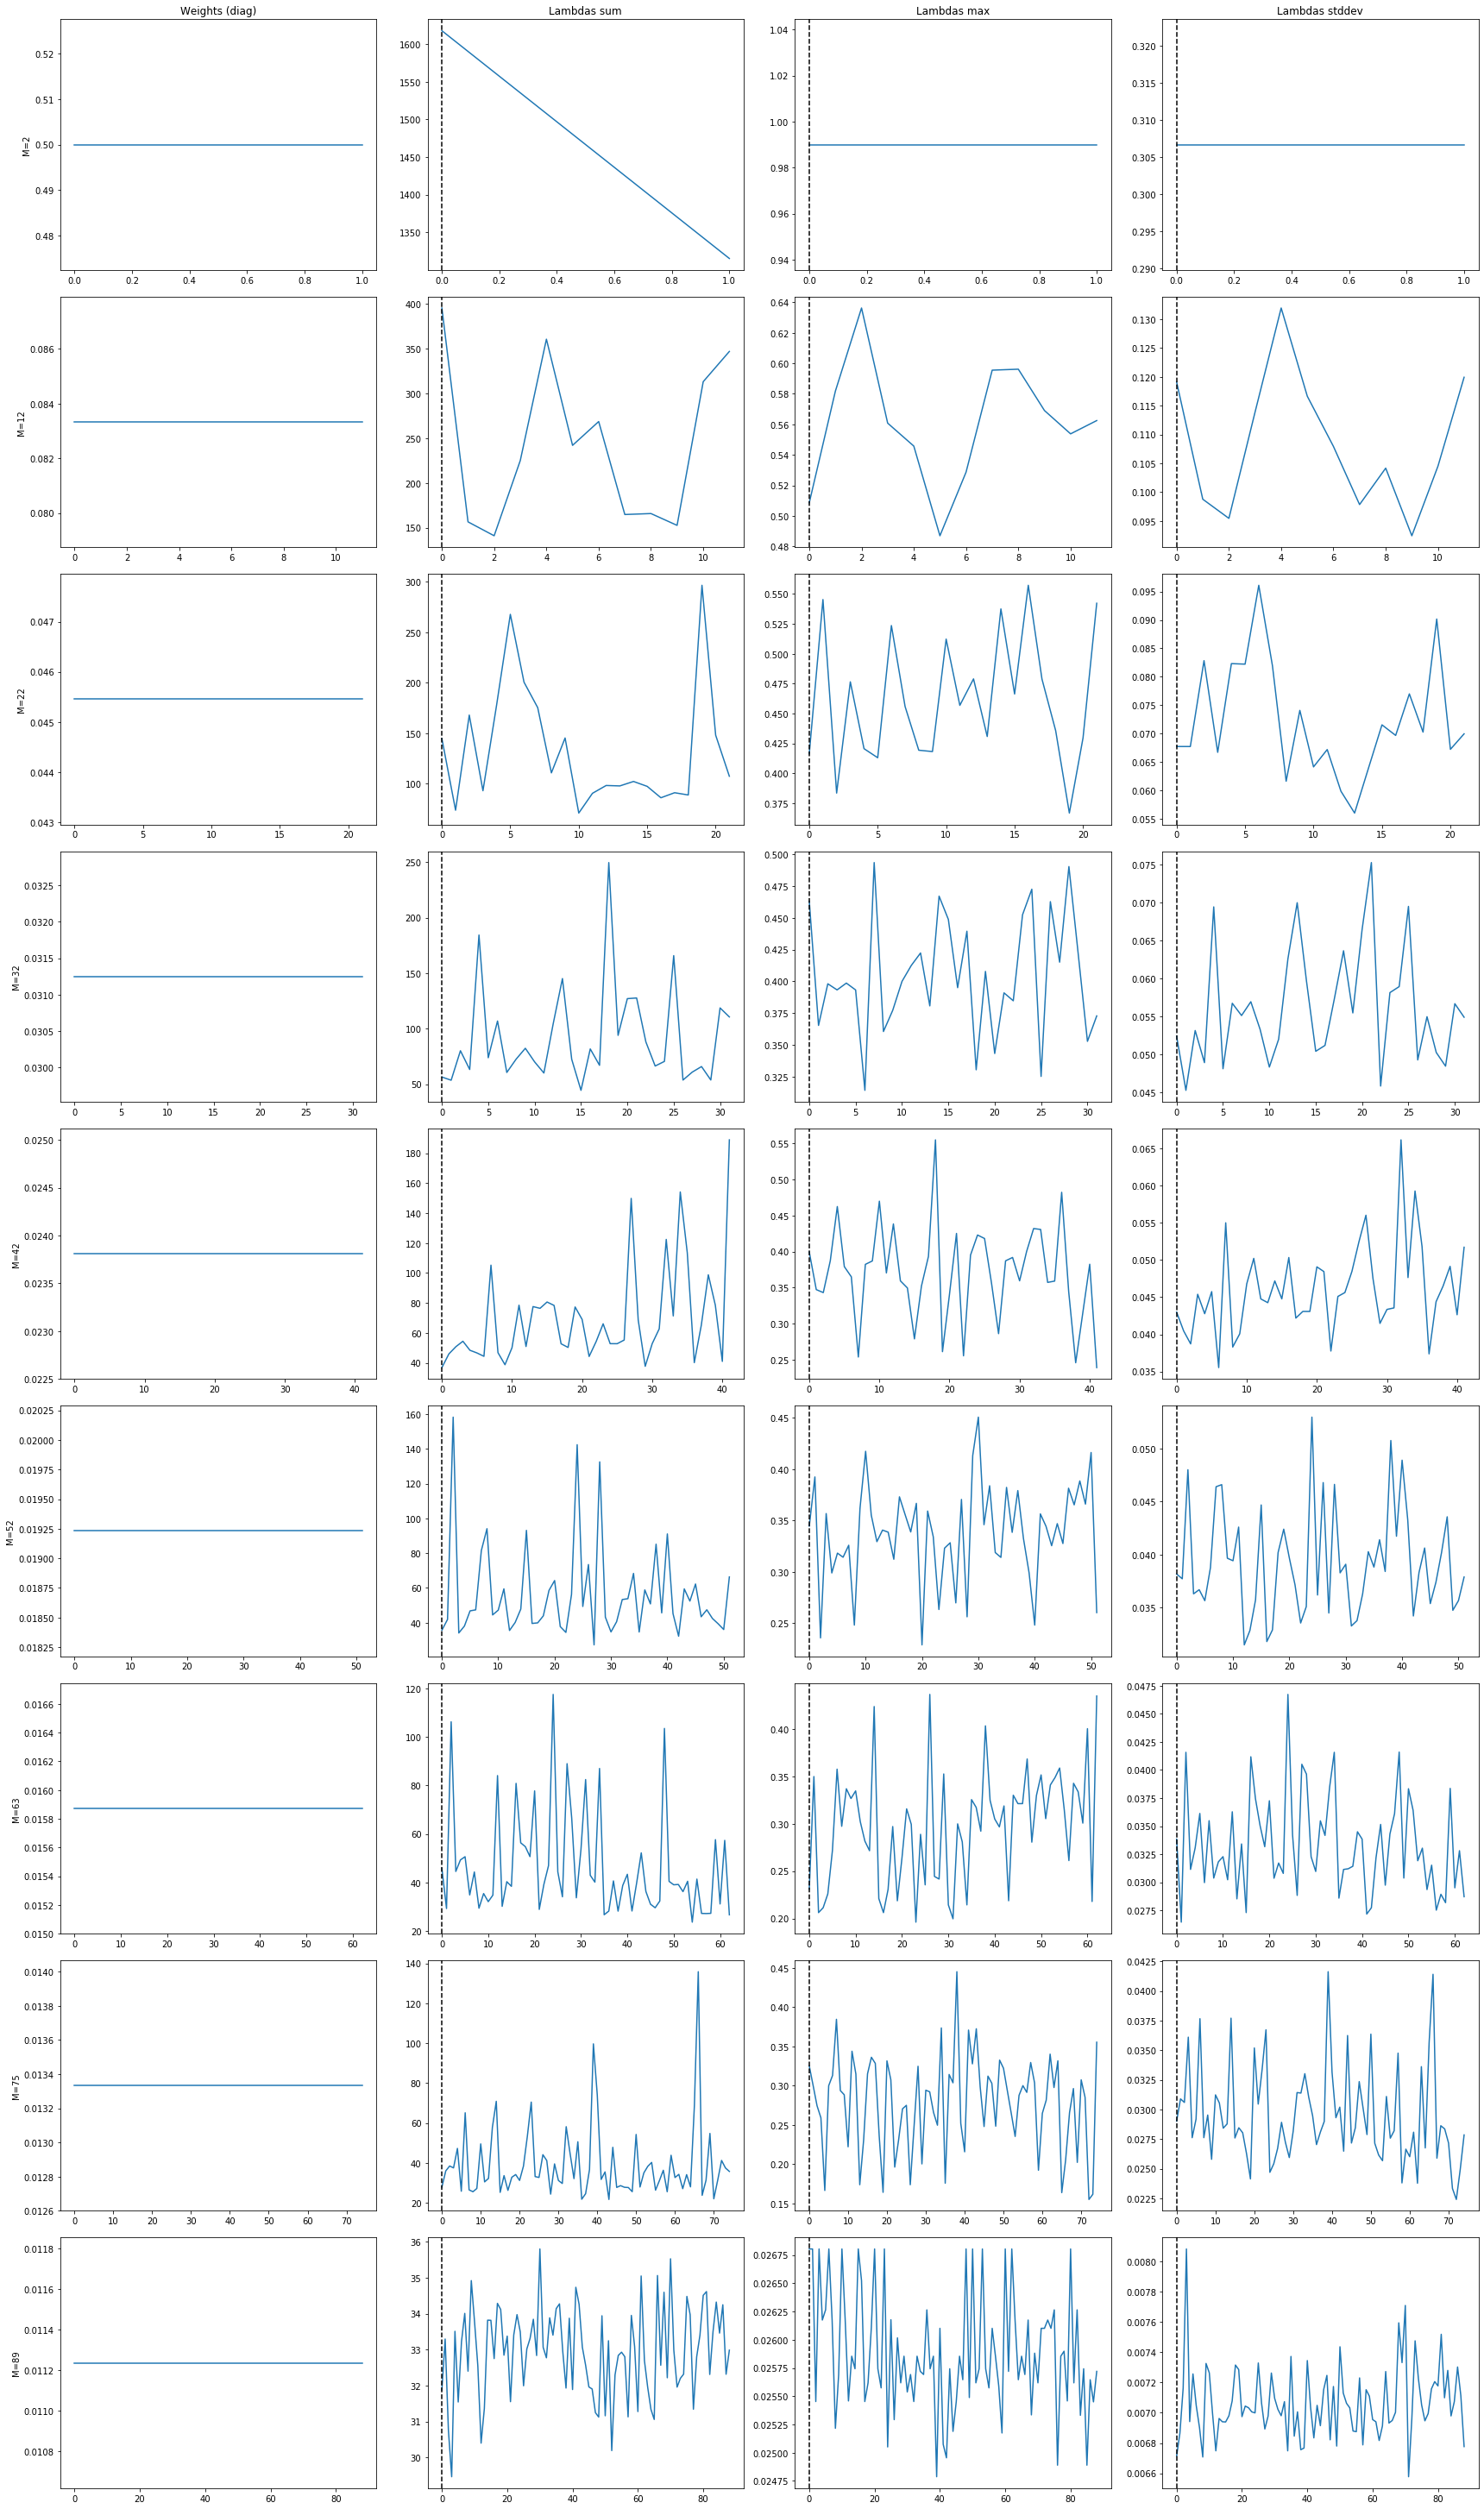

In [397]:
fit_eye = list(filter(None, [eye(n) for n in range(101)]))
plot_all(fit_eye[1:100:10])

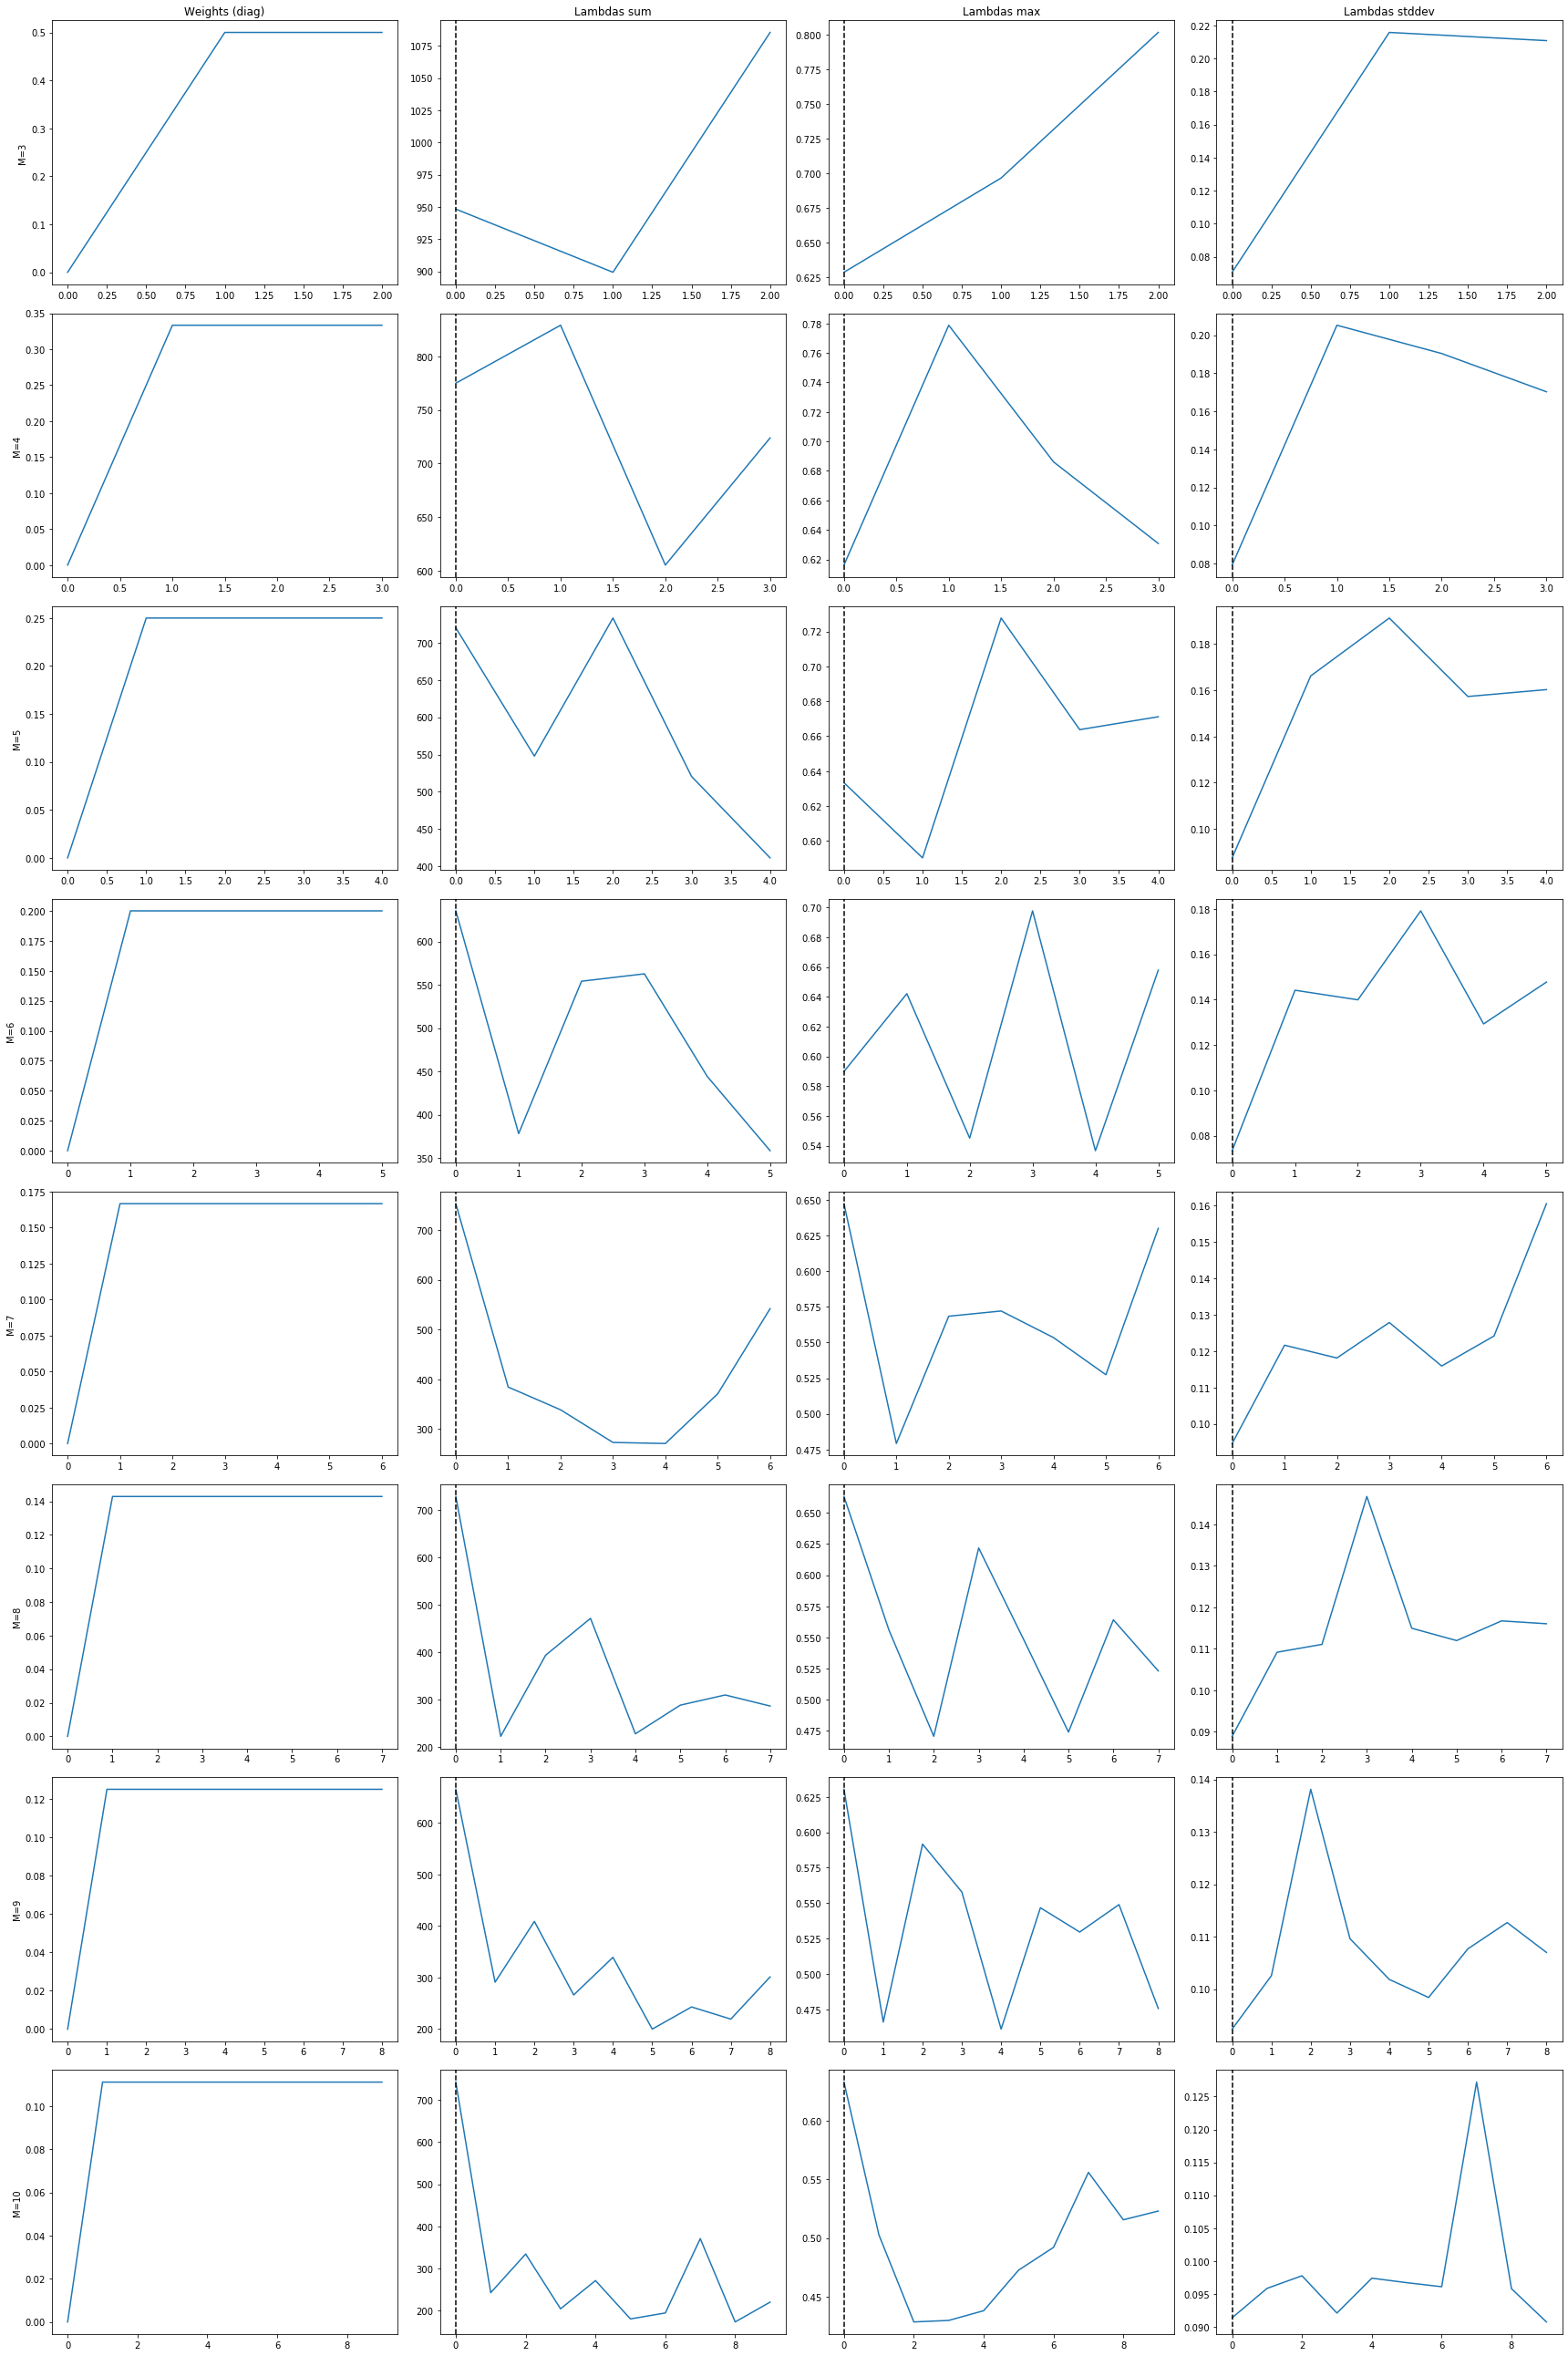

In [380]:
fit_eye_with_empty = list(filter(None, [eye_with_empty(n) for n in range(101)]))
plot_all(fit_eye_with_empty[2:10])

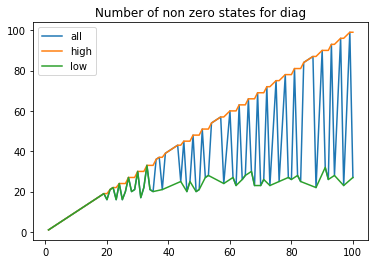

In [306]:
fit_diag = list(filter(None, [diag(n) for n in range(101)]))
diag_nonzero = compose(list, unzip, map(juxt(len, np.sum)), map(operator.lt(0)), map(np.sort), map(np.diag), pluck_weights)(fit_diag)
diag_high = compose(list, juxt(first, compose(list, accumulate(max), second)))(diag_nonzero)
plt.plot(*diag_nonzero)
plt.plot(*diag_high)
plt.plot(*compose(unzip, filter(compose(operator.gt(35), second)), unpack_args(zip))(diag_nonzero))
plt.title("Number of non zero states for diag")
plt.legend(['all', 'high', 'low'])

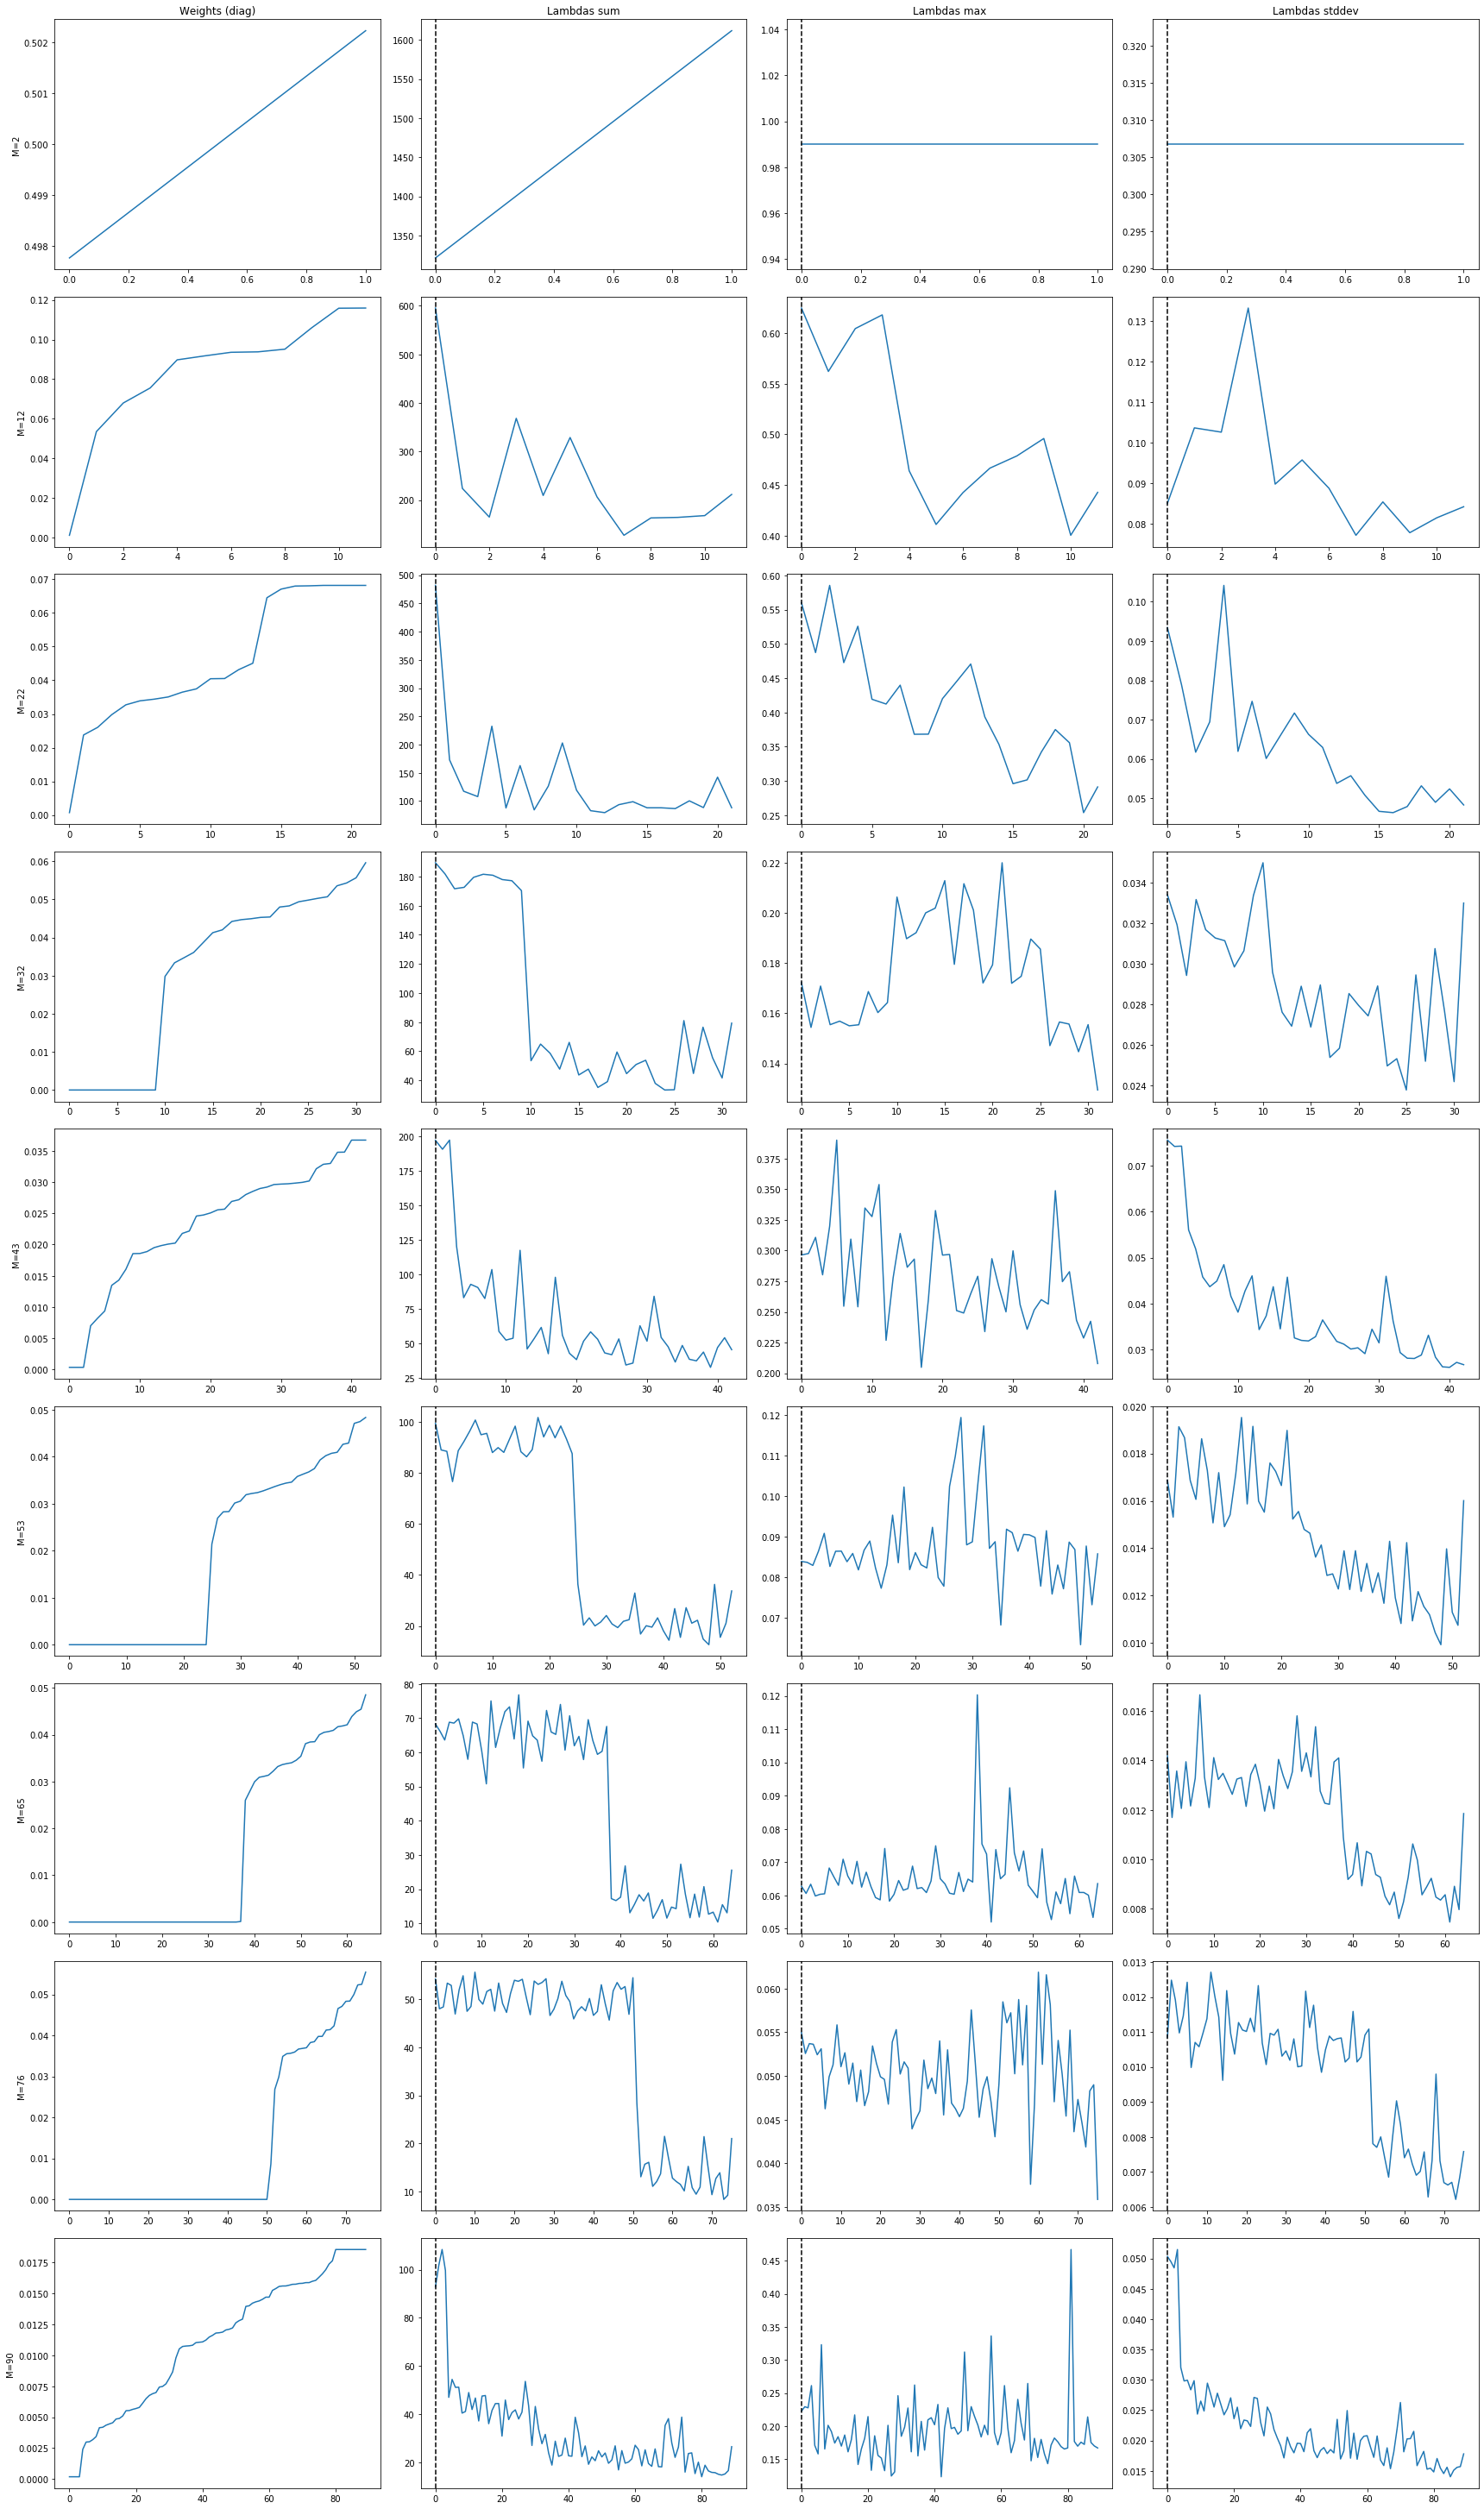

In [307]:
plot_all(fit_diag[1:100:10])

In [311]:
import visualize

In [343]:
visualize.all_figures(input_data, fit_eye[1].values(), fit_eye[2].values(), histones_dir='histone_modifications/')

In [314]:
fit_eye[30].values()

ValuesView(<numpy.lib.npyio.NpzFile object at 0x11d5521d0>)

In [355]:
fit_diag = list(filter(None, [diag(n) for n in range(101)]))
diag_nonzero = compose(list, unzip, map(juxt(len, np.sum)), map(operator.lt(0)), map(np.sort), map(np.diag), pluck_weights)(fit_diag)
plt.plot(*diag_nonzero)
plt.title("Number of non zero states for diag")
n_states, lr_n = unzip(lr_diag)
ax = plt.gca()
plt.grid(axis='x', which='both')
ax2 = ax.twinx()
ax2.plot(n_states, lr_n)


In [356]:
diag_try2 = fit_dir('rao2015-chr20-try2/diag')

Text(0.5, 1.0, 'Number of non zero states for diag')

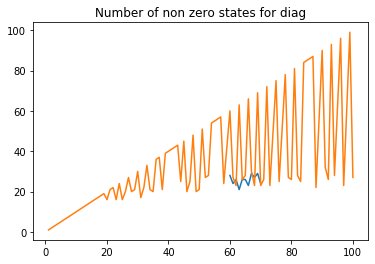

In [366]:
fit_diag_try2 = list(filter(None, [diag_try2(n) for n in range(101)]))
diag_nonzero_try2 = compose(list, unzip, map(juxt(len, np.sum)), map(operator.lt(0)), map(np.sort), map(np.diag), pluck_weights)(fit_diag_try2)
plt.plot(*diag_nonzero_try2)
plt.plot(*diag_nonzero)
plt.title("Number of non zero states for diag")


In [359]:
lr_diag_try2 = compose(list,
                 map(juxt(first,
                          compose(unpack_args(lr_input), operator.methodcaller('values'), second))),
                 filter(compose(operator.is_not(None), second)),
                 map(juxt(identity, diag_try2)))(range(2, 101))

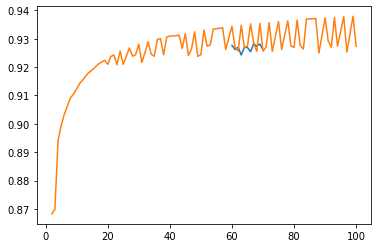

In [367]:
plt.plot(*unzip(lr_diag_try2))
plt.plot(*unzip(lr_diag))

In [363]:
eye_with_empty_try2 = fit_dir('rao2015-chr20-try2/eye_with_empty/')

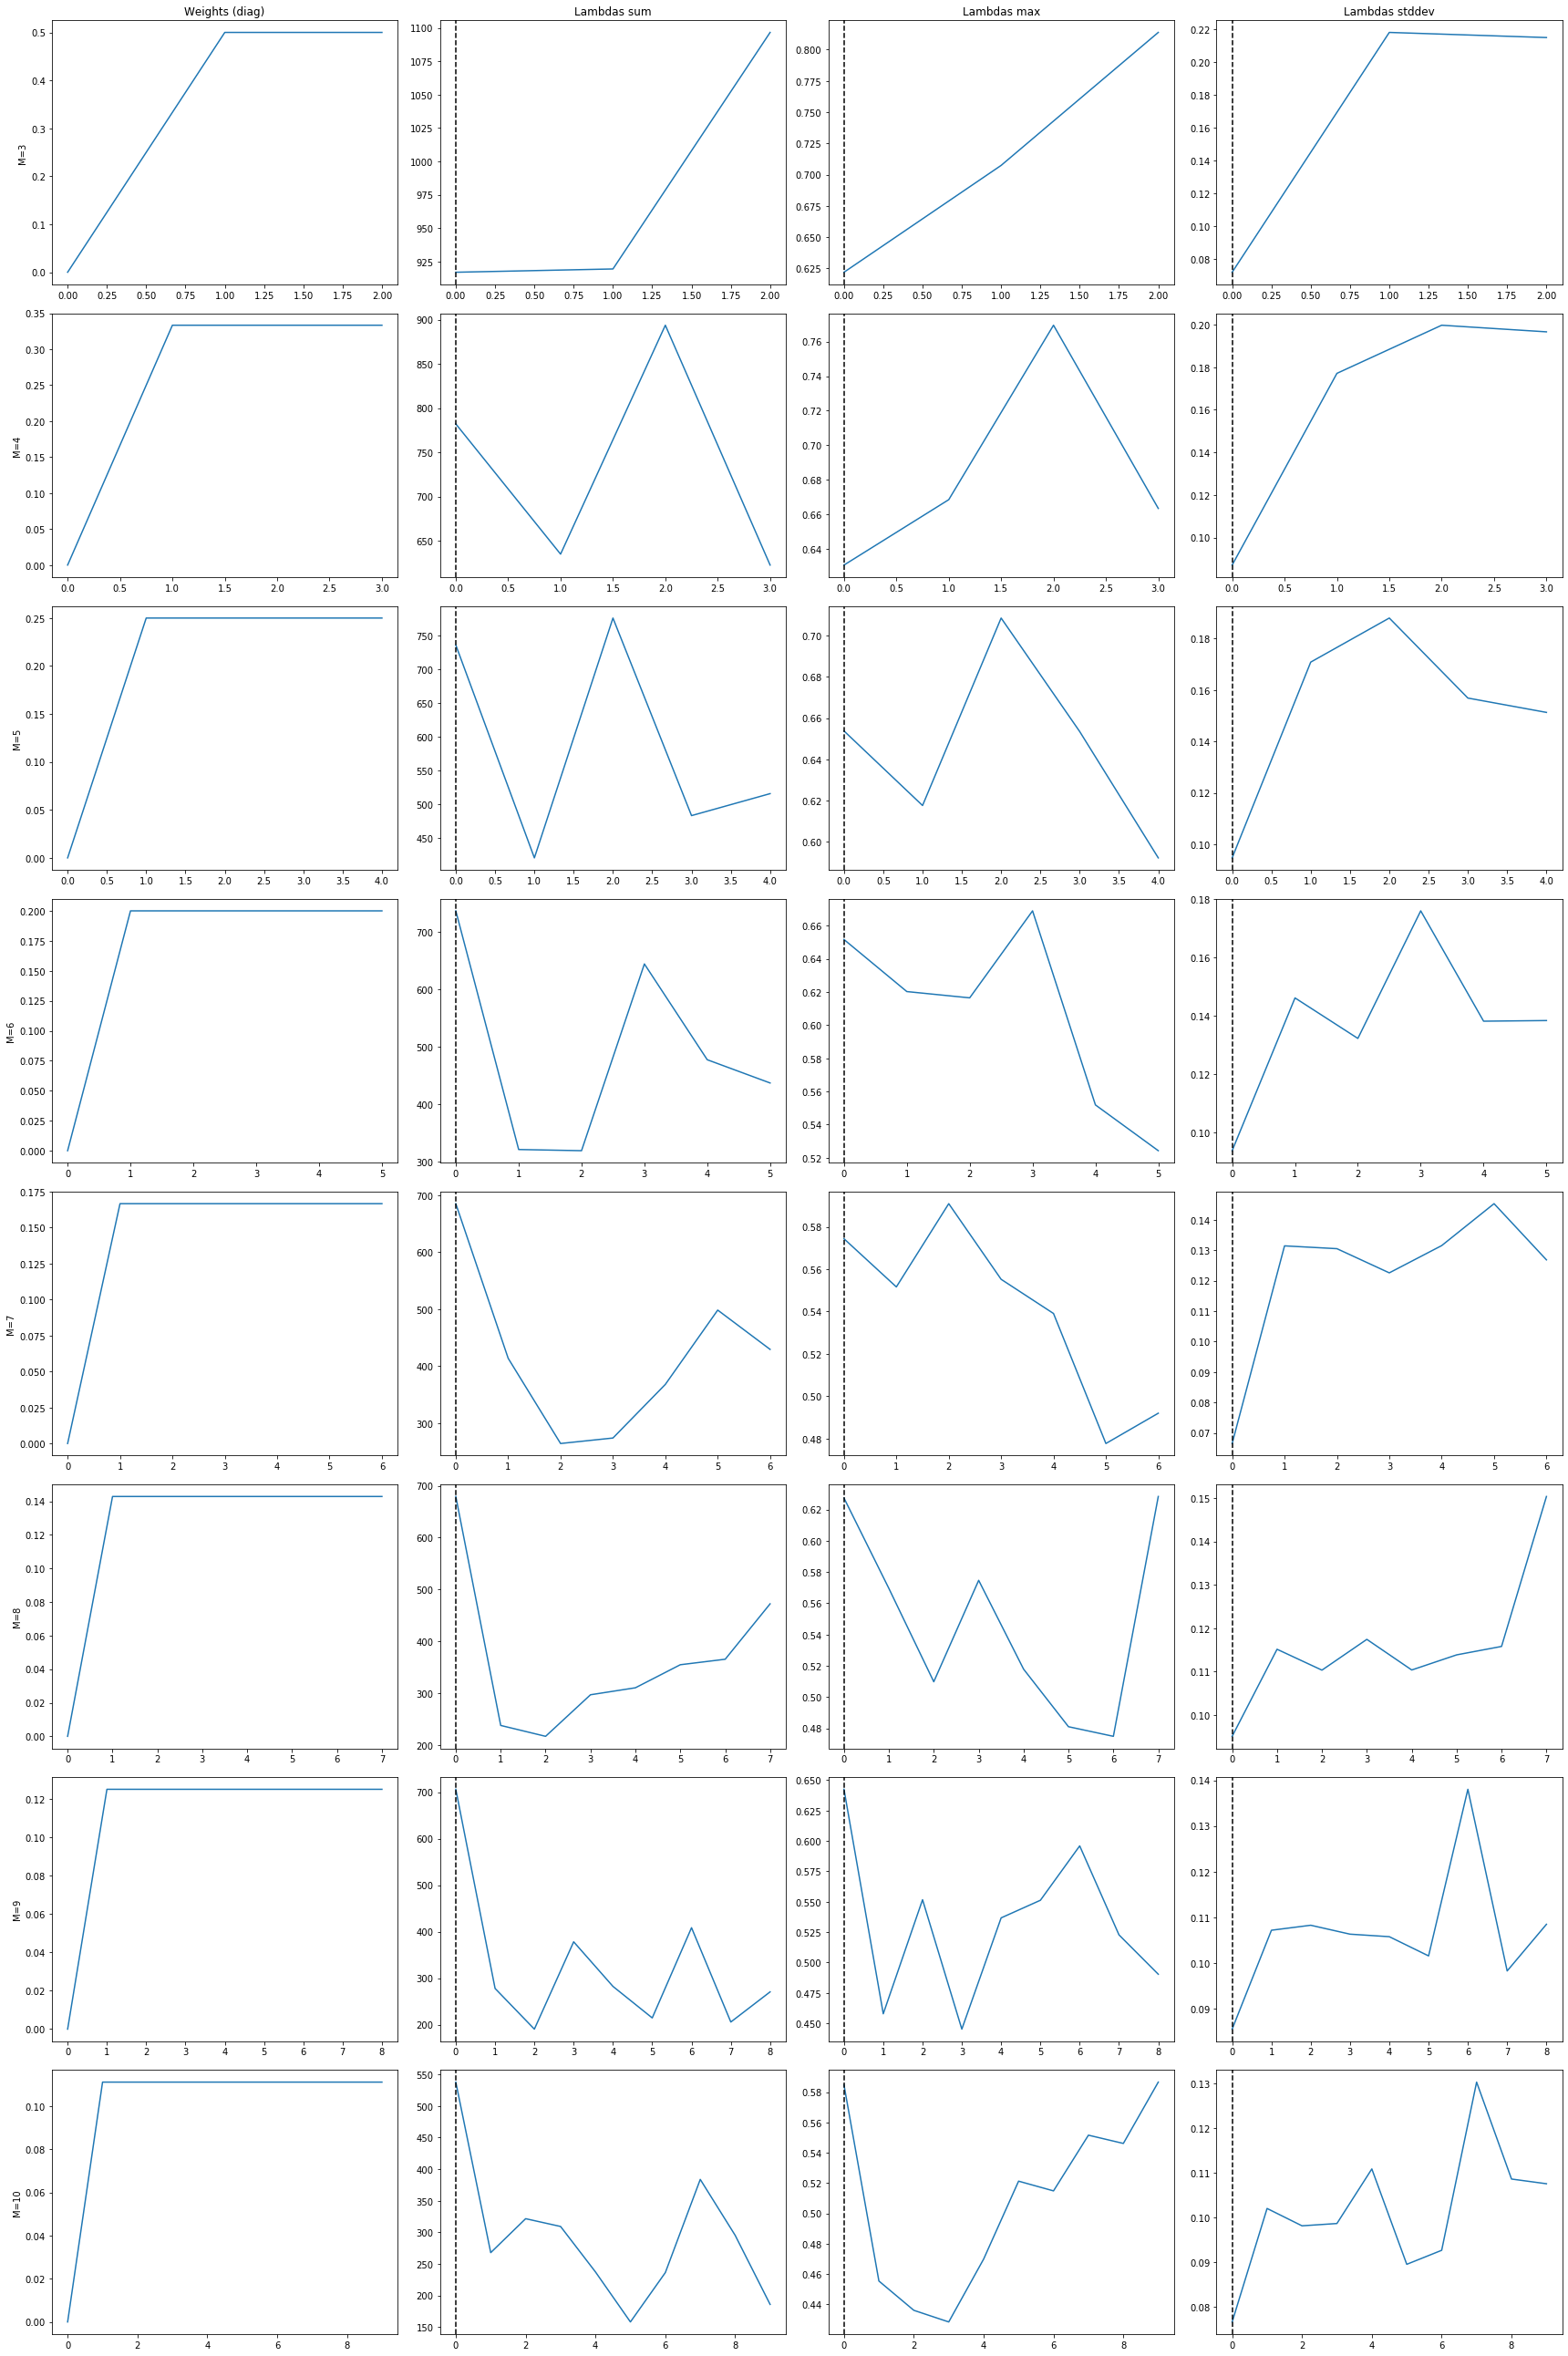

In [365]:
%matplotlib inline
fit_eye_with_empty_try2 = list(filter(None, [eye_with_empty_try2(n) for n in range(101)]))
plot_all(fit_eye_with_empty_try2[1:100])

In [379]:
a = np.nansum(gc.generate_interactions_matrix(*fit_eye_with_empty_try2[3].values()), axis=1)
a[a!= 0]

array([0.00044716, 0.00049516, 0.0005024 , ..., 0.00055152, 0.00051619,
       0.00046337])

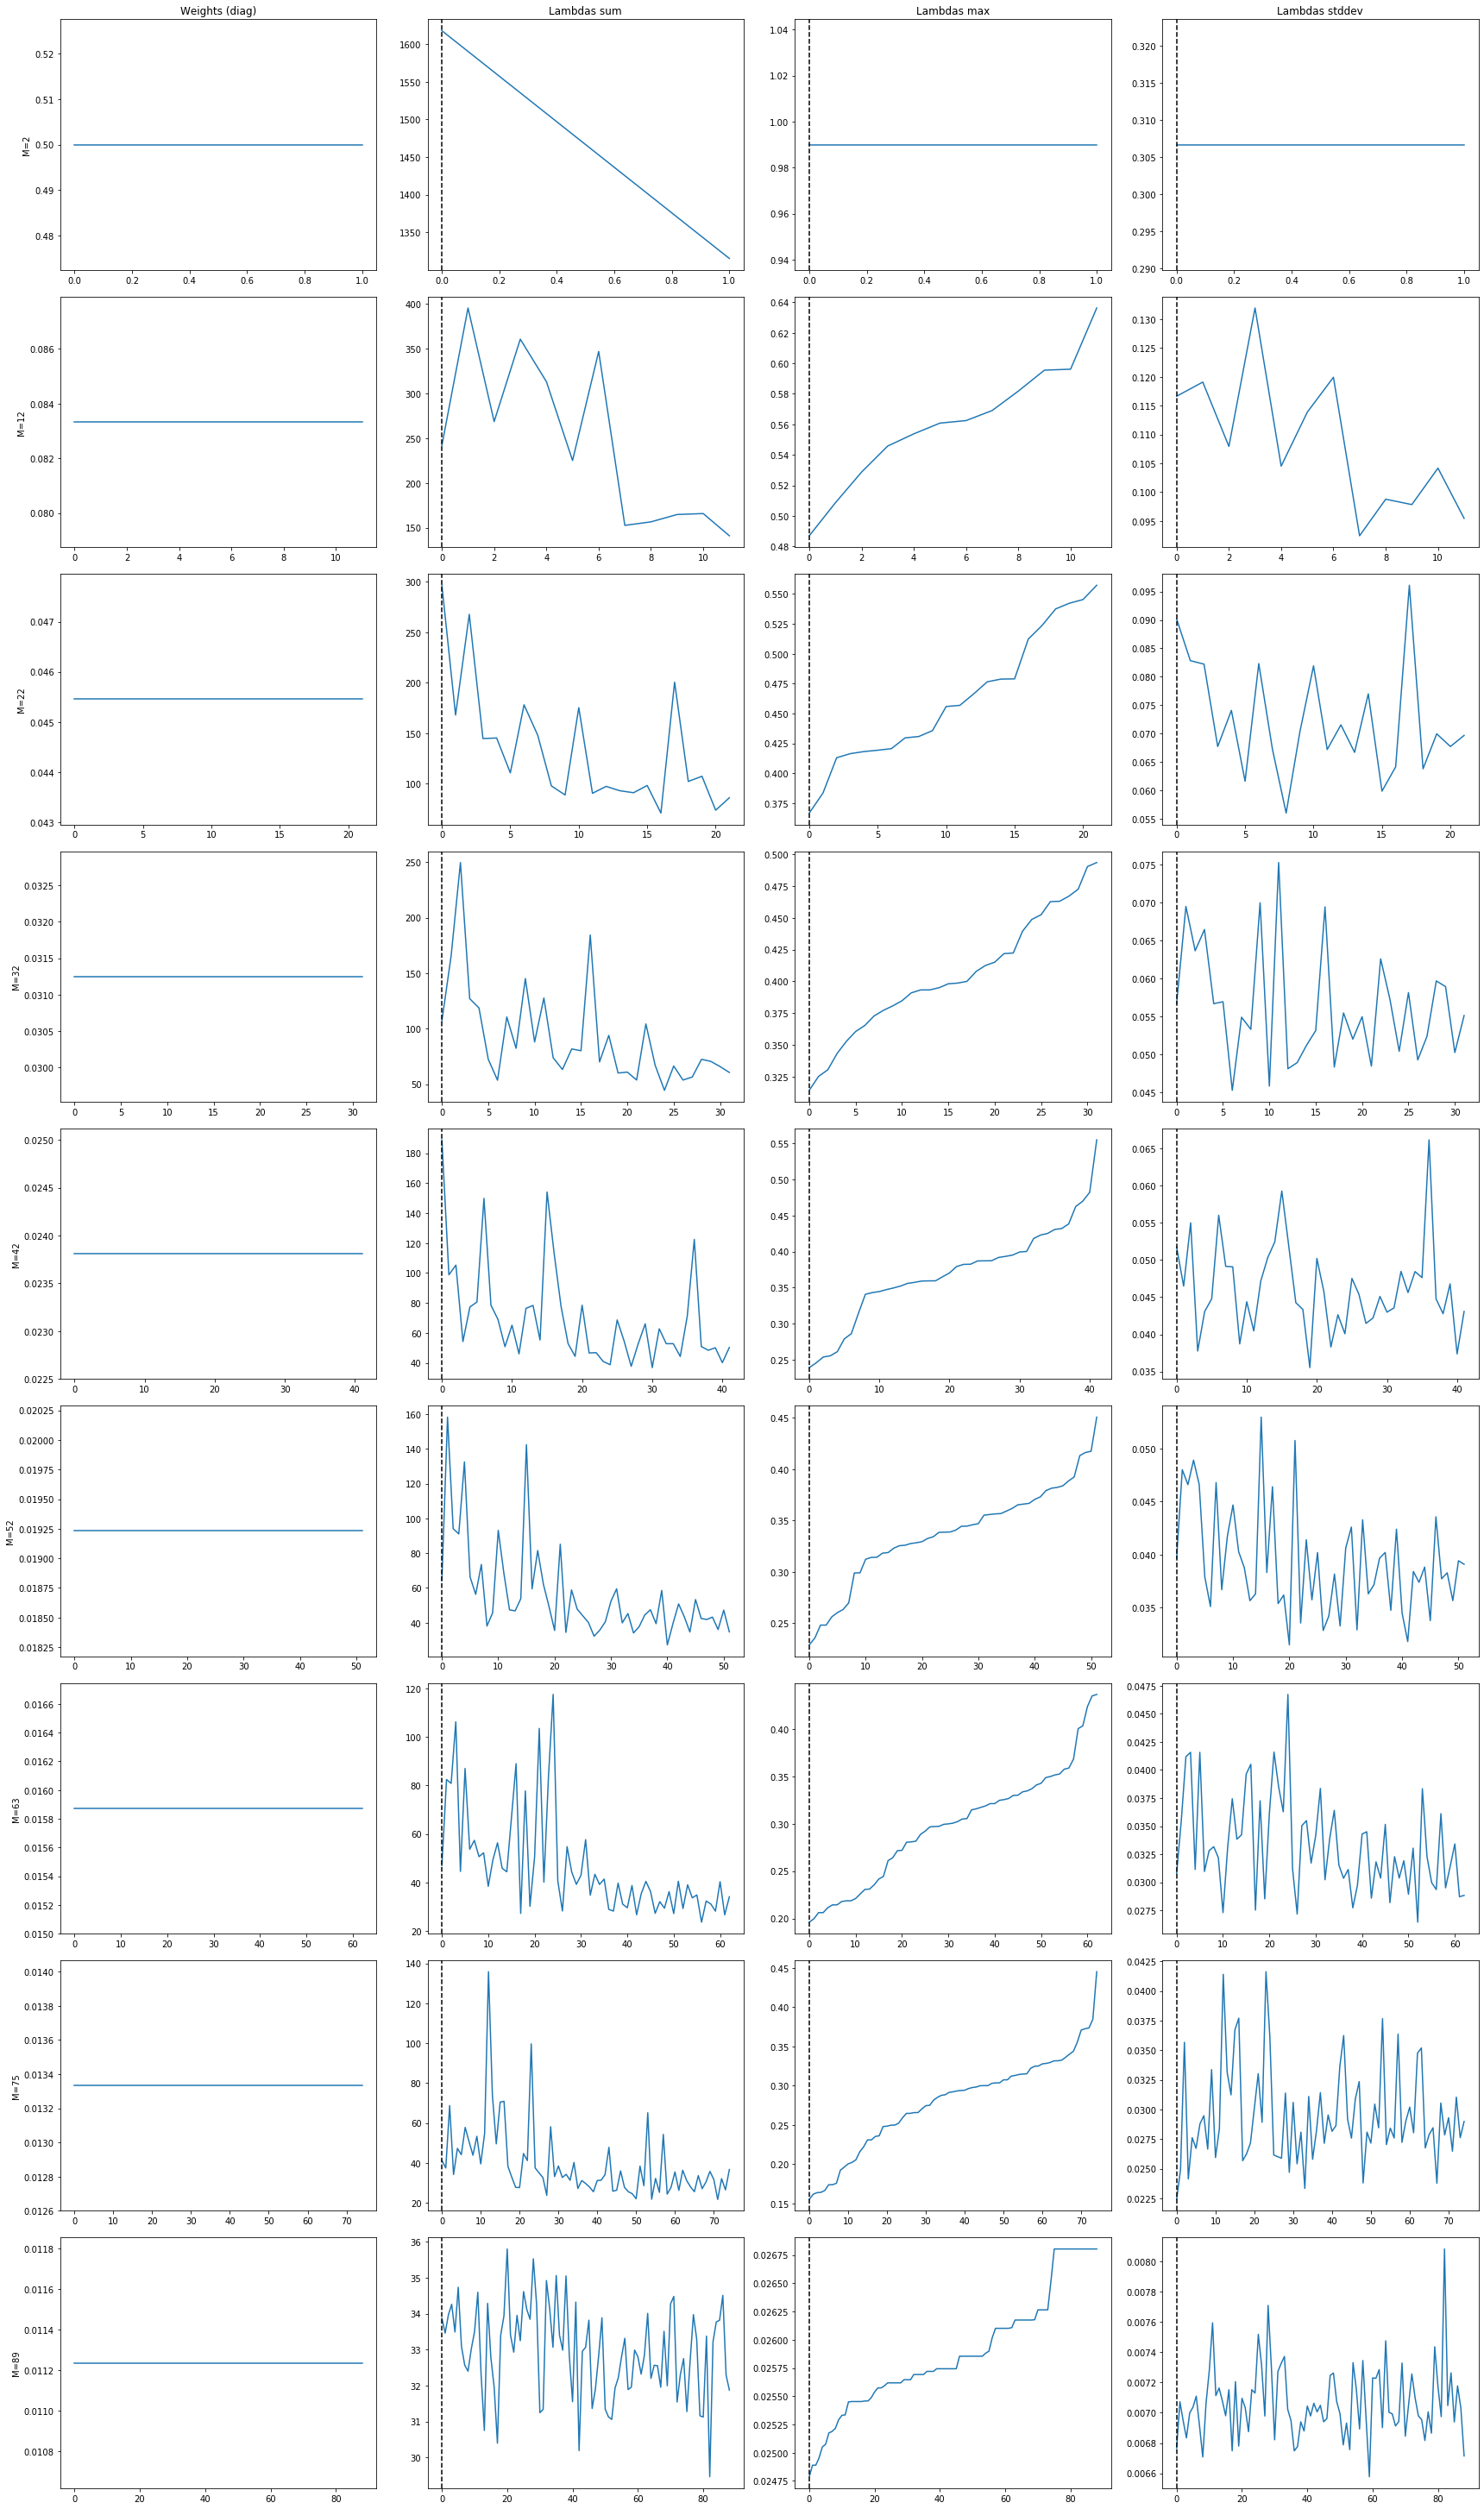

In [418]:
plot_all(fit_eye[1:100:10], order_func=lambda i, w, s, m, sd: np.argsort(m))

In [409]:
lambdas_colsum = compose(list, map(partial(np.nansum, axis=0)), pluck_lambdas)([eye(89), eye(88)])

In [419]:
np.argsort(lambdas_colsum[1])[-1]

76

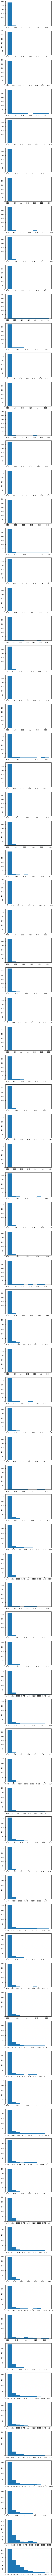

In [445]:
hist = compose(plt.hist, list, remove(np.isnan), get(seq=eye(88)['lambdas']))
o = np.argsort(lambdas_colsum[1])
plt.figure(figsize=(1.5*4, 1.3*3*len(o)))
for i,s in enumerate(o):
    plt.subplot(len(o), 1, i+1)
    hist((slice(None), s))

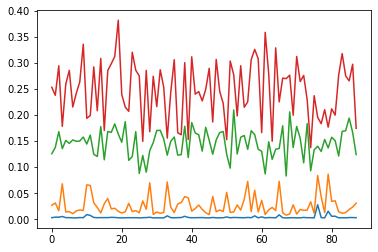

In [470]:
plt.plot(np.nanpercentile(eye(88)['lambdas'], [50, 90, 99, 100], axis=0).T)

In [503]:
percentiles = compose(np.transpose, partial(np.nanpercentile, q=[50, 75, 90, 100], axis=0))

@curry
def order_by_col(col, a):
    order = np.argsort(a[:, col])
    return a[order, :]

@curry
def plot_percentile(total, i, p):
    ax = plt.subplot(total, 1, i+1)
    ax.plot(p[:, :-1])
    ax.legend(['p50', 'p75', 'p90', 'p100'])
    ax.set_ylabel('Lambda value')
    ax.set_xlabel('State #')
    ax2 = ax.twinx()
    ax2.plot(p[:, -1], c='purple')
    ax2.legend(['sum'])
    ax2.set_ylabel('Lambda sum')
    plt.title(f'M={p.shape[0]}')

nrow_figure = lambda n: plt.figure(figsize=(4*1.5, 3*1.5*n))

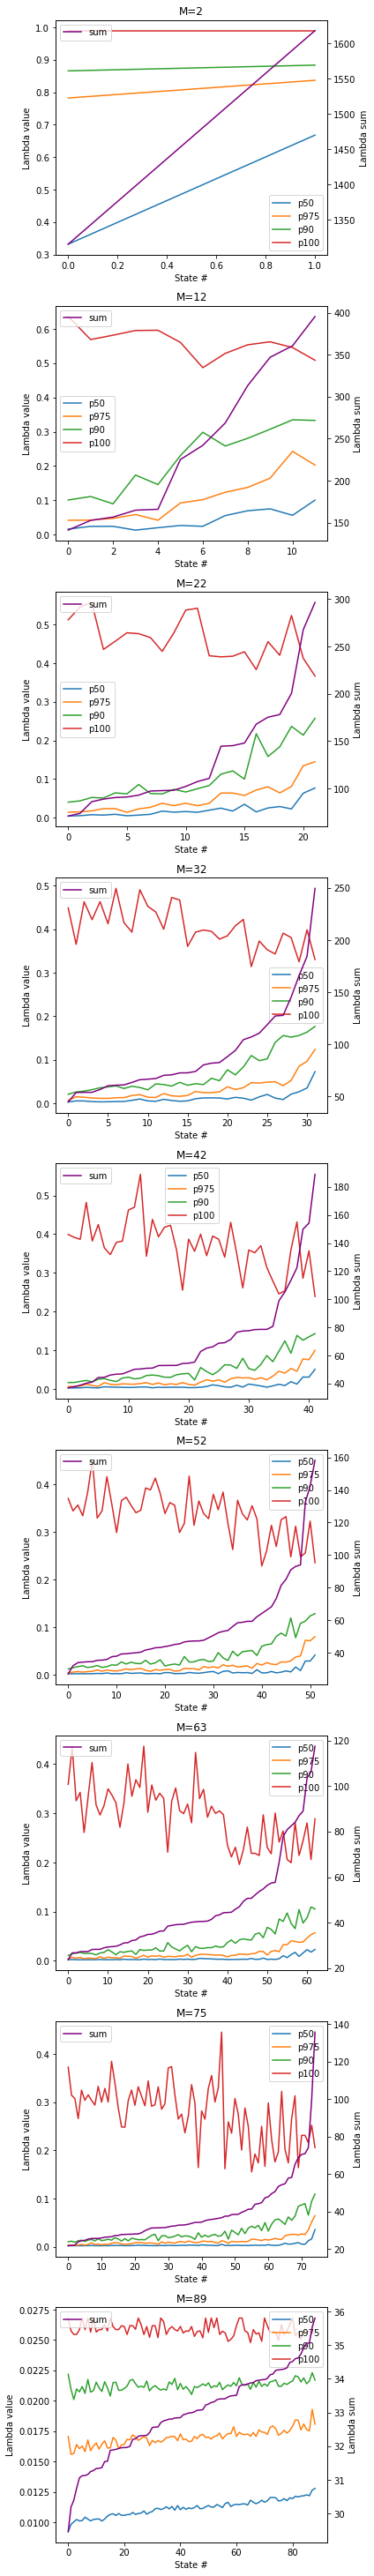

In [506]:
nrow_figure(len(fit_eye))
_ = compose(list,
        map(unpack_args(plot_percentile(len(fit_eye)))),
        enumerate,
        map(order_by_col(-1)),
        map(compose(np.column_stack, juxt(percentiles, partial(np.nansum, axis=0)))),
        pluck_lambdas)(fit_eye[1:100:10])
plt.tight_layout()

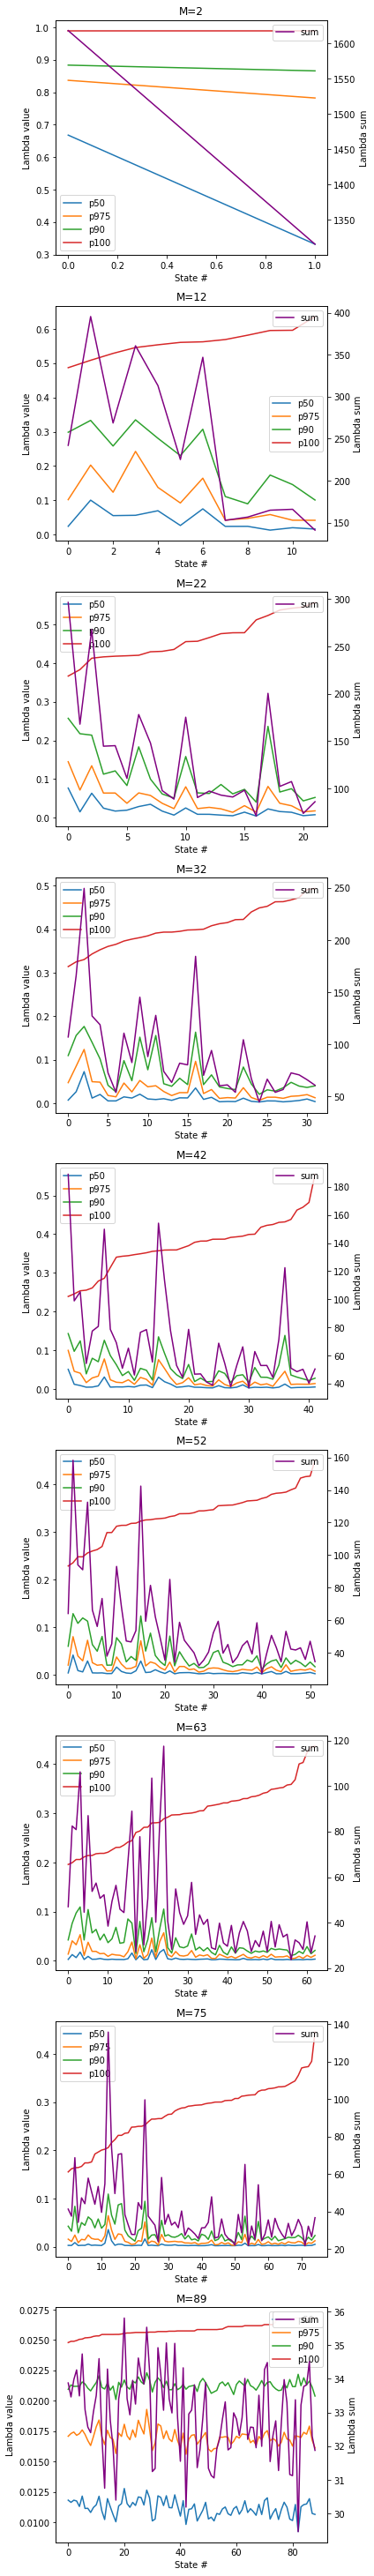

In [507]:
nrow_figure(len(fit_eye))
_ = compose(list,
        map(unpack_args(plot_percentile(len(fit_eye)))),
        enumerate,
        map(order_by_col(-2)),
        map(compose(np.column_stack, juxt(percentiles, partial(np.nansum, axis=0)))),
        pluck_lambdas)(fit_eye[1:100:10])
plt.tight_layout()

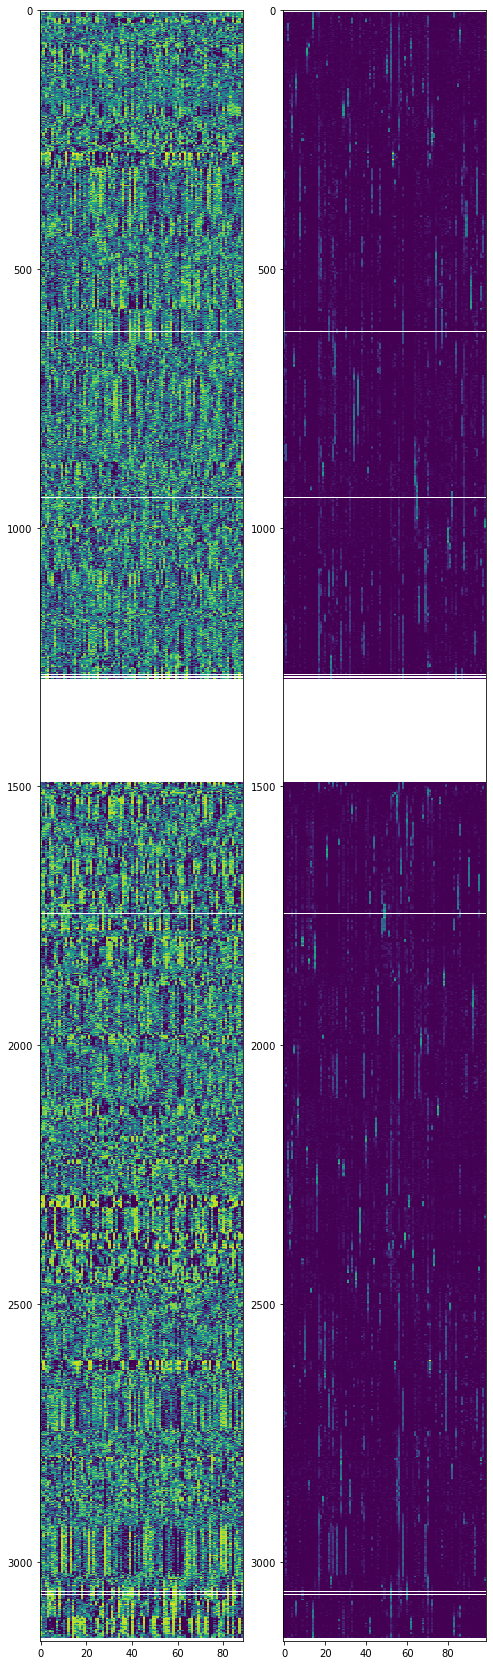

In [525]:
plt.figure(figsize=(2*4,30))
plt.subplot(1, 2, 1)
plt.imshow(eye(89)['lambdas'], aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(eye(99)['lambdas'], aspect='auto')

In [551]:
np.argsort(np.nanmax(eye(75)['lambdas'], axis=0))[0]

20

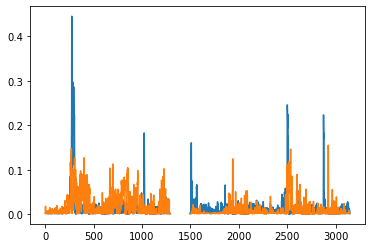

In [556]:
plt.plot(eye(75)['lambdas'][:, 35])
plt.plot(eye(75)['lambdas'][:, 20])

/Users/hkariti/anaconda3/envs/kaplanlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Text(0, 0.5, 'Pct empty (< half of uniform)')

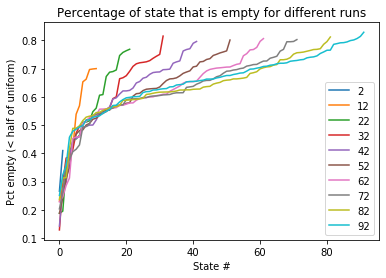

In [610]:
for i in range(2, 100, 10):
    e = eye(i)
    if e is None:
        continue
    plt.plot(np.sort(np.mean(e['lambdas'] < 1/i/2, axis=0)), label=i)
plt.legend()
plt.title("Percentage of state that is empty for different runs")
plt.xlabel("State #")
plt.ylabel("Pct empty (< half of uniform)")